# Urban Sound Classification: Pre-Processing

### Introduction

This Jupyter notebook was created by Filipe Barros, Gonçalo Arrobas and João Barão for the Machine Learning II.

### Import Statements

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

### Loading MetaData

In [3]:
print("Loading CSV file {}".format('UrbanSound8K.csv'))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv('UrbanSound8K.csv')

# Examine dataframe's head
metadata.head()

Loading CSV file UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


### Dataset Download

%run download_dataset.py

### Feature Extraction Approach

In [3]:
row=metadata.sample(1)
file_path = 'audio' + '/fold'+ str(row.iloc[0,5]) +'/' + str(row.iloc[0,0])
y, sr = librosa.load(file_path)
normalized_y = librosa.util.normalize(y)

#####  Mel-Frequency Cepstral Coefficients (MFCCs)

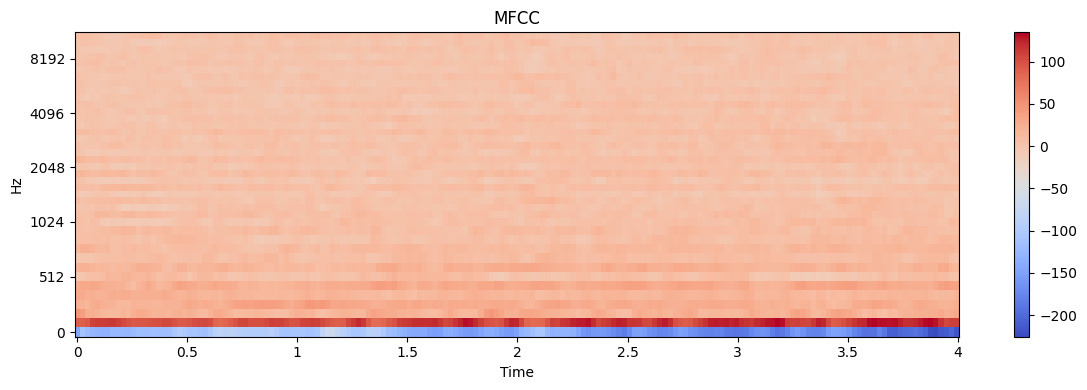

In [4]:
# Generate MFCC coefficients
mfcc = librosa.feature.mfcc(y=normalized_y, sr=sr, n_mfcc=40)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

##### Spectrograms

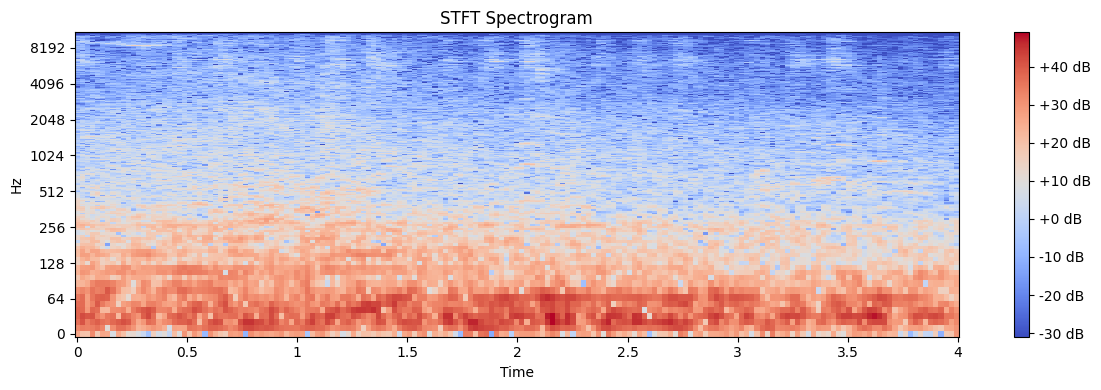

In [5]:
# Compute STFT
stft = librosa.core.stft(normalized_y, n_fft=2048, hop_length=512)

# Convert sound intensity to log amplitude:
stft_db = librosa.amplitude_to_db(abs(stft))


# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT Spectrogram')
plt.tight_layout()
plt.show()

### Feature Extraction

In [ ]:
def augment_audio(y, sr):
    noise = np.random.randn(len(y))
    y_pitch_shifted = librosa.effects.pitch_shift(y, sr, n_steps=4)
    y_time_stretched = librosa.effects.time_stretch(y, 1.0)
    noisy_audio1 = y + 0.02 * noise
    
    return y_pitch_shifted, y_time_stretched, noisy_audio1

In [4]:
def get_features(y,sr, n_mfcc):
    hop_length = 512

    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    y = librosa.util.normalize(y) # Normalize audio data between -1 and 1
    
    features=[]

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(1, 14):
        features.append(mfccs[i - 1])
        
    return features

In [5]:
def add_padding(features, mfcc_max_padding=174):
    padded = []

    # Add padding in both sides
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < mfcc_max_padding):
            xDiff = mfcc_max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded

In [4]:
def envelope_moving_average(signal, window_size=100):
    envelope = np.convolve(np.abs(signal), np.ones(window_size)/window_size, mode='same')
    return envelope

##### Extracting Audio Signal - 1D

In [4]:
metadata = pd.read_csv('UrbanSound8K.csv')
frames_max = 0
total_samples = len(metadata)
desired_duration = 4  # seconds
sample_rate = 1000  # Hz (samples per second)
desired_length = sample_rate * desired_duration

# Initialize X_folds and y_folds as lists
X_folds = [[] for _ in range(10)]  # List of lists, each sublist corresponds to a fold's features
y_folds = [[] for _ in range(10)]

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath('audio'), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    fold_value = row['fold'] - 1
    class_id = row['classID']
    y, sr = librosa.load(file_path, sr=sample_rate)
    y = librosa.util.normalize(y)
    if len(y) < desired_length:
        # Pad with zeros (at the end) if the audio is shorter than 4 seconds
        y = np.pad(y, (0, desired_length - len(y)))
    else:
        # Truncate if the audio is longer than 4 seconds
        y = y[:desired_length]

    X_folds[fold_value].append(y)
    y_folds[fold_value].append(class_id)
    
print("Finished: {}/{}".format(index+1, total_samples))

Finished: 8732/8732


In [6]:
metadata = pd.read_csv('UrbanSound8K.csv')
frames_max = 0
total_samples = len(metadata)
desired_duration = 4  # seconds
sample_rate = 1000  # Hz (samples per second)
desired_length = sample_rate * desired_duration

# Initialize X_folds and y_folds as lists
X_folds = [[] for _ in range(10)]  # List of lists, each sublist corresponds to a fold's features
y_folds = [[] for _ in range(10)]

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath('audio'), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    fold_value = row['fold'] - 1
    class_id = row['classID']
    y, sr = librosa.load(file_path, sr=sample_rate)
    y = envelope_moving_average(y)  
    if len(y) < desired_length:
        # Pad with zeros (at the end) if the audio is shorter than 4 seconds
        y = np.pad(y, (0, desired_length - len(y)))
    else:
        # Truncate if the audio is longer than 4 seconds
        y = y[:desired_length]

    X_folds[fold_value].append(y)
    y_folds[fold_value].append(class_id)
    
print("Finished: {}/{}".format(index+1, total_samples))

Finished: 8732/8732


In [7]:
X_folds = [np.array(fold) for fold in X_folds]
y_folds = [np.array(fold) for fold in y_folds]

In [8]:
for i in range(10):
    np.save(f'fold{i + 1}1d_envelope_features.npy', X_folds[i])
    np.save(f'fold{i + 1}1d_envelope_labels.npy', y_folds[i])

print("X_folds and y_folds have been saved successfully.")

X_folds and y_folds have been saved successfully.


##### Extracting Mel-frequency cepstral coefficients (MFCCs) - 2D

In [8]:
frames_max = 0
total_samples = len(metadata)
n_mfcc = 13

# Initialize X_folds and y_folds as lists
X_folds = [[] for _ in range(10)]  # List of lists, each sublist corresponds to a fold's features
y_folds = [[] for _ in range(10)]

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath('audio'), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    fold_value = row['fold'] - 1
    class_id = row['classID']
    y, sr = librosa.load(file_path)
    #y_pitch, y_noisy, y_time = augment_audio(y, sr)
    # Extract MFCCs (do not add padding)
    features = get_features(y, sr, n_mfcc)
    #features_noisy_1 = get_features(y_pitch, sr, n_mfcc)
    #features_noisy_2 = get_features(y_noisy_2, sr, n_mfcc)
    # Save current frame count
    num_frames = features[-1].shape[0]
    
    X_folds[fold_value].append(features)
    #X_folds[fold_value].append(features_noisy_1)
    #X_folds[fold_value].append(features_noisy_2)
    y_folds[fold_value].append(class_id)
    #y_folds[fold_value].append(class_id)
    #y_folds[fold_value].append(class_id)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames
    
print("Finished: {}/{}".format(index+1, total_samples))

c:\Users\Utilizador\anaconda3\envs\lessgo\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Utilizador\anaconda3\envs\lessgo\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Utilizador\anaconda3\envs\lessgo\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Finished: 8732/8732


In [9]:
X_folds_padded = [[] for _ in range(10)]
for i in range(len(X_folds)):
    X_folds_padded[i]=add_padding(X_folds[i])

In [10]:
for i in range(10):
    np.save(f'fold_{i + 1}_13mfcc_features.npy', X_folds_padded[i])
    np.save(f'fold_{i + 1}_13mfcc_labels.npy', y_folds[i])

print("X_folds and y_folds have been saved successfully.")

X_folds and y_folds have been saved successfully.


##### Extracting Mel Spectograms - 2D

In [9]:
metadata = pd.read_csv('UrbanSound8K.csv')
frames_max = 0
total_samples = len(metadata)

# Initialize X_folds and y_folds as lists
X_folds = [[] for _ in range(10)]  # List of lists, each sublist corresponds to a fold's features
y_folds = [[] for _ in range(10)]

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath('audio'), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    fold_value = row['fold'] - 1
    class_id = row['classID']
    y, sr = librosa.load(file_path)
    n_fft = 2048               # Number of FFT components
    hop_length = 512           # Number of samples between successive frames
    n_mels = 80              # Number of Mel bands
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    features = librosa.power_to_db(mel_spectrogram, ref=np.max)
    X_folds[fold_value].append(features)
    y_folds[fold_value].append(class_id)

    
print("Finished: {}/{}".format(index+1, total_samples))

c:\Users\Utilizador\anaconda3\envs\lessgo\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Utilizador\anaconda3\envs\lessgo\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Utilizador\anaconda3\envs\lessgo\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Finished: 8732/8732


In [10]:
X_folds_padded = [[] for _ in range(10)]
for i in range(len(X_folds)):
    X_folds_padded[i]=add_padding(X_folds[i])

In [11]:
for i in range(10):
    np.save(f'fold{i + 1}mel80_features.npy', X_folds_padded[i])
    np.save(f'fold{i + 1}mel80_labels.npy', y_folds[i])

print("X_folds and y_folds have been saved successfully.")

X_folds and y_folds have been saved successfully.
